In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os

from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
# Helper functions / cached data
reports = os.listdir('reports')

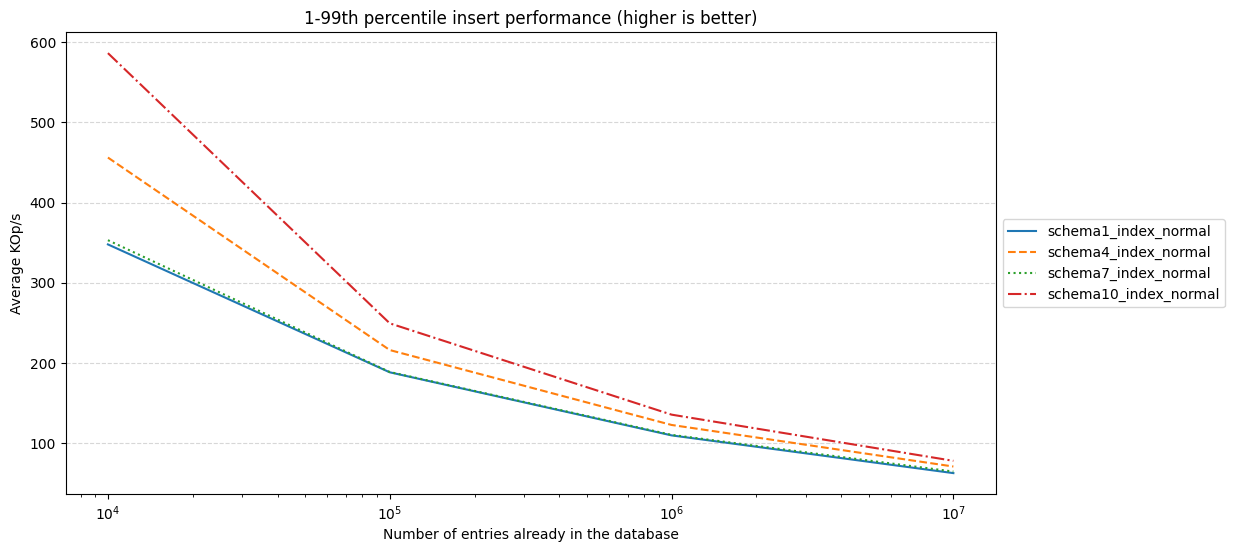

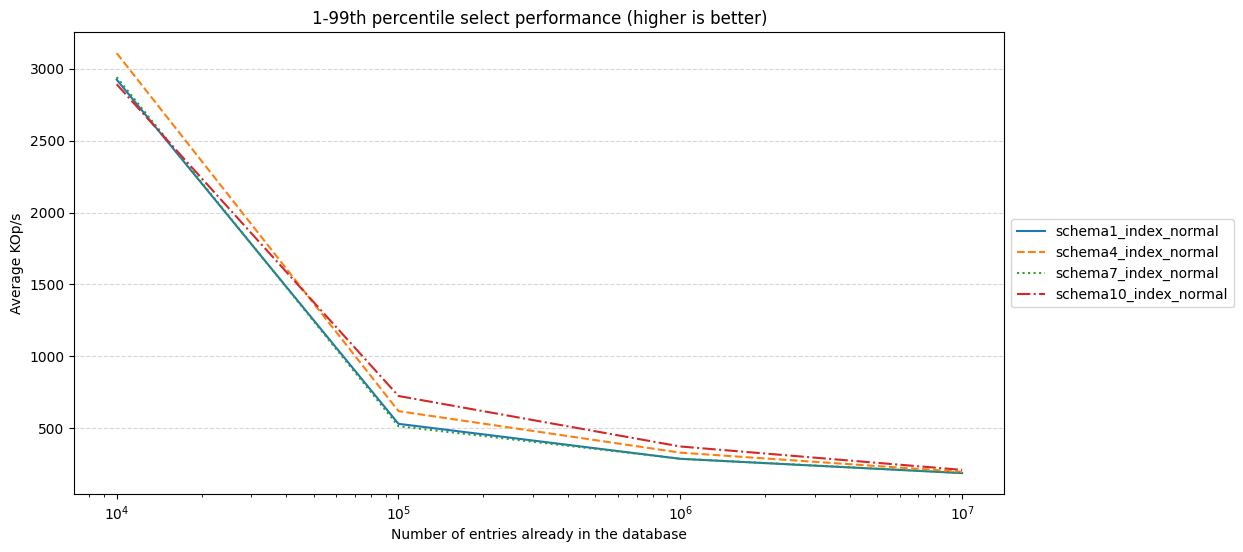

In [56]:
# Schemas
def read_schemas(filename):
    result = dict()
    sub_benchmarks = ['insert', 'select']
    for sub in sub_benchmarks:
        sub_dict = dict()
        matches = [f for f in reports if f.startswith(f'{filename}_{sub}')]
        for match in matches:
            subsub_dict = dict()
            subsub = match.removeprefix(f'{filename}_{sub}_').removesuffix('.csv')
            with open(f'reports/{match}', 'r') as f:
                lines = f.readlines()
            column_names = lines[0].strip().split(',')
            for line in lines[1:]:
                inner = dict()
                values = line.strip().split(',')
                entries = int(values[0])
                for i in range(3, len(column_names)):
                    inner[column_names[i]] = float(values[i])
                subsub_dict[entries] = inner
            sub_dict[subsub] = subsub_dict
        result[sub] = sub_dict
    return result

styles = ['solid', 'dashed', 'dotted', 'dashdot']
def plot_schema(idx, benchmark, style):
    schema = read_schemas(f'schema{idx}')
    for strategy in schema[benchmark]:
        values = [(k, v['1-99_avg_kops']) for k, v in schema[benchmark][strategy].items()]
        x, y = zip(*values)
        plt.plot(x, y, label=f'schema{idx}_{strategy}', linestyle=style)

# Scaling on number of entries in the database prior to running
for b in ['insert', 'select']:
    plt.figure(figsize=(12, 6))
    # Horizontal grid for each y tick
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i, schema in enumerate([1, 4, 7, 10]):
        plot_schema(schema, b, styles[i % len(styles)])

    plt.title(f'1-99th percentile {b} performance (higher is better)')
    plt.xlabel('Number of entries already in the database')
    plt.ylabel('Average KOp/s')
    plt.xscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

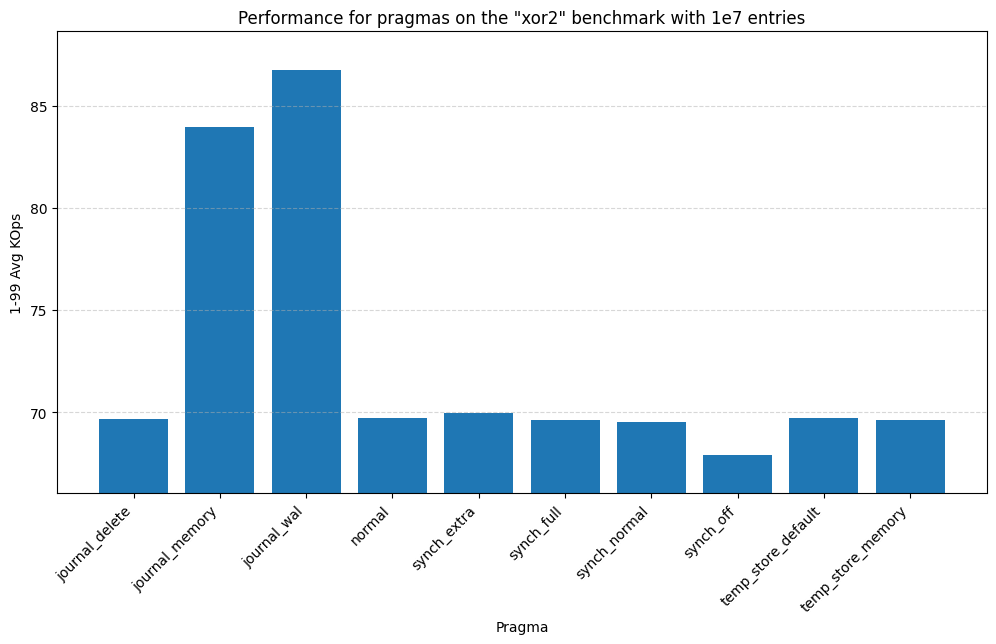

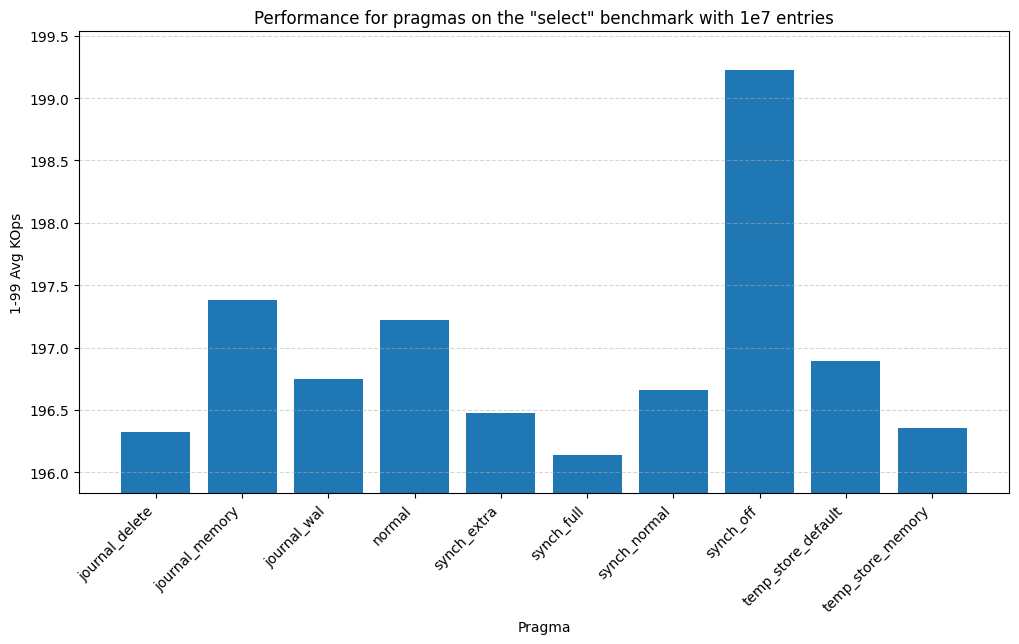

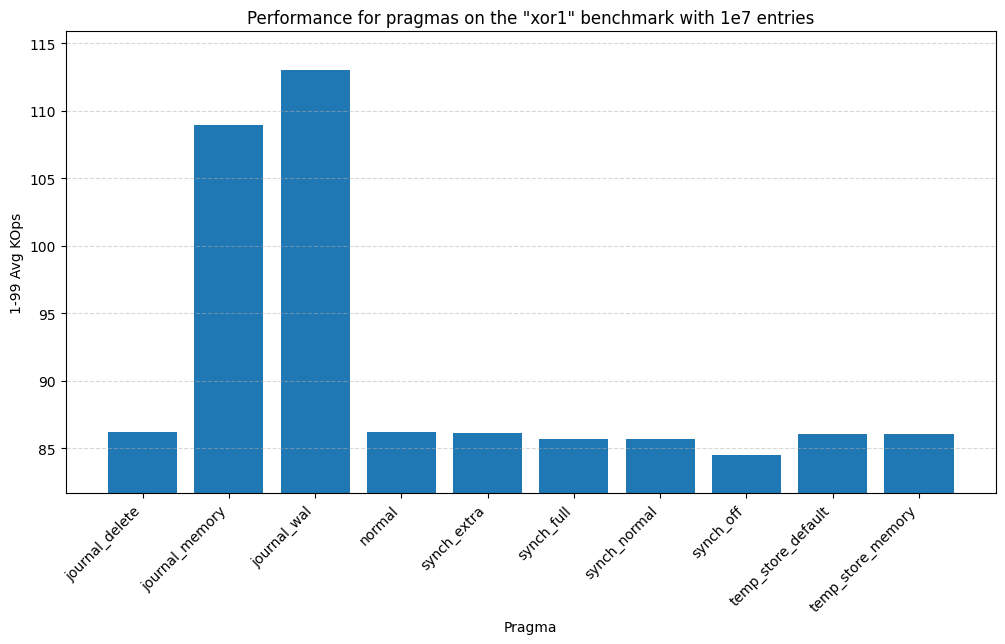

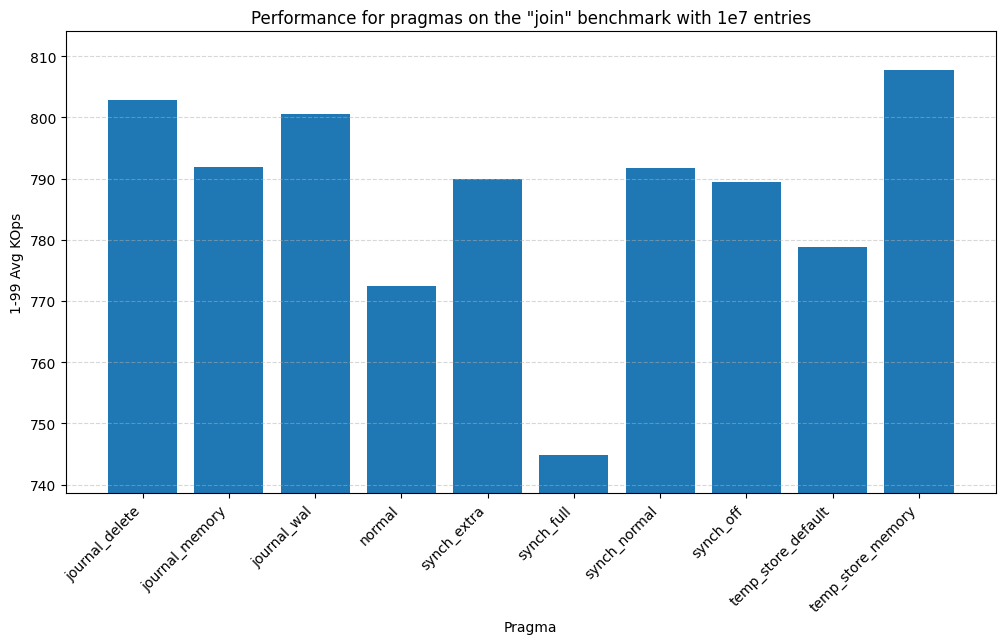

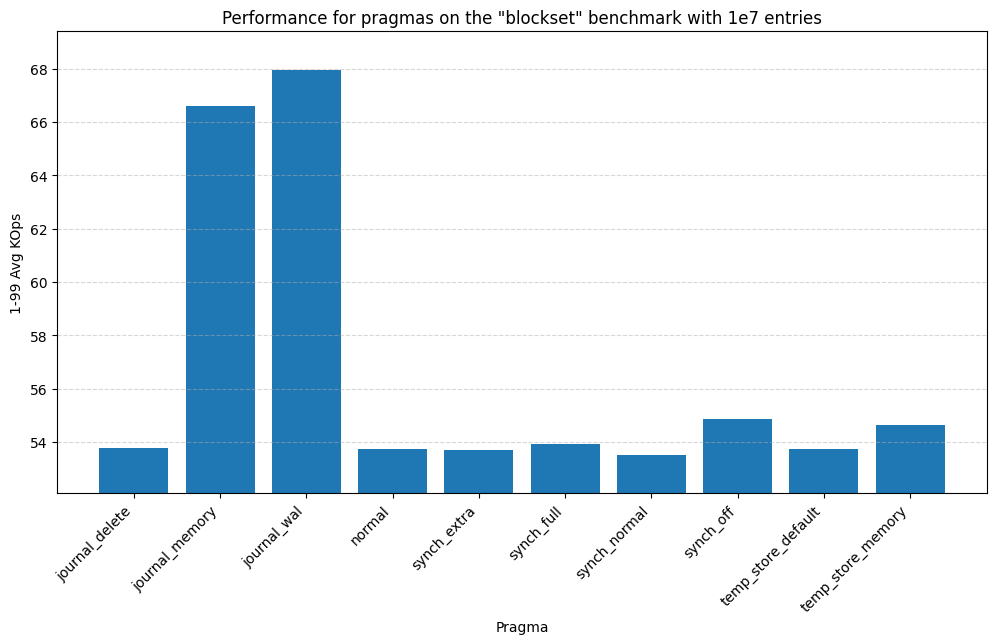

In [ ]:
benchmarks = list(set([(f.split('_'))[1] for f in reports if f.startswith('pragmas')]))
def read_pragmas():
    result = dict()
    for b in benchmarks:
        result[b] = dict()
        matches = [f for f in reports if f.startswith(f'pragmas_{b}_')]
        for match in matches:
            subsub = match.removeprefix(f'pragmas_{b}_').removesuffix('.csv')
            result[b][subsub] = dict()
            with open(f'reports/{match}', 'r') as f:
                lines = f.readlines()
            column_names = lines[0].strip().split(',')
            for line in lines[1:]:
                inner = dict()
                values = line.strip().split(',')
                entries = int(values[0])
                for i in range(3, len(column_names)):
                    inner[column_names[i]] = float(values[i])
                result[b][subsub][entries] = inner
    return result

def plot_pragmas_surface(b, sbl, sbs):
    xs = []
    ys = []
    zs = []
    for i, sb in enumerate(sbs):
        for ee in range(4):
            xs.append(ee)
            ys.append(i)
            zs.append(values[b][f'{sbl}_{sb}'][10**(ee+4)]['1-99_avg_kops'])

    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))

    xx, yy = np.meshgrid(np.unique(xs), np.unique(ys))
    xs, ys = xx.ravel(), yy.ravel()
    zs = zs.reshape(xx.shape)
    surf = ax.plot_surface(xx, yy, zs, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('Number of entries')
    ax.set_ylabel('Pragma value')
    ax.set_zlabel('1-99 Avg KOps')
    ax.set_yticks(np.arange(len(sbs)), labels=sbs)
    ax.set_xticks(xs, labels=[f'1e{(x+4)}' for x in xs])
    plt.title(f'Performance for tuning the {sbl} pragma on the "{b}" benchmark')
    plt.show()

def plot_pragmas_curves(b, sbl, sbs):
    plt.figure(figsize=(12, 6))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i, sb in enumerate(sbs):
        xs = []
        ys = []
        zs = []
        for ee in range(4):
            xs.append(10**(ee+4))
            ys.append(i)
            zs.append(values[b][f'{sbl}_{sb}'][10**(ee+4)]['1-99_avg_kops'])

        plt.plot(xs, zs, label=f'{sbl}_{sb}')

    plt.xlabel('Number of entries')
    plt.ylabel('1-99 Avg KOps')
    plt.title(f'Performance for tuning the {sbl} pragma on the "{b}" benchmark')
    plt.xscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def plot_pragmas_bar(b, e):
    pragmas = [f.removeprefix(f'pragmas_{b}_').removesuffix('.csv') for f in reports if f.startswith(f'pragmas_{b}_')]
    kops = [values[b][p][10**(e+4)]['1-99_avg_kops'] for p in pragmas]

    plt.figure(figsize=(12, 6))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.bar(pragmas, kops)
    vrange = max(kops) - min(kops)
    plt.ylim(min(kops) - 0.1 * vrange, max(kops) + 0.1 * vrange)
    plt.xlabel('Pragma')
    plt.ylabel('1-99 Avg KOps')
    plt.title(f'Performance for pragmas on the "{b}" benchmark with 1e{(e+4)} entries')
    plt.xticks(rotation=45, ha='right')
    plt.show()

values = read_pragmas()
#b = 'select'
for b in benchmarks:
    #sbl = 'temp_store'
    #sbs = [f.removeprefix(f'pragmas_{b}_{sbl}_').removesuffix('.csv') for f in reports if f.startswith(f'pragmas_{b}_{sbl}')]
    #plot_pragmas_curves(b, sbl, sbs)

    for e in range(3,4):
        try:
            plot_pragmas_bar(b, e)
        except:
            pass
